In [1]:
import math
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

%load_ext autoreload
%autoreload 2

# Project code
from bayesian_optimizer import BayesianOptimizer, AcquisitionFunc

# Set seed so result is reproducible
np.random.seed(12345)


# Figures for ECE 524 Machine Learning Final Project

### Utility functions:

In [2]:
def normalize(x: np.array) -> np.array:
    '''Helper function used to normalize values between 0 and 1'''
    return (x-np.min(x))/(np.max(x)-np.min(x))


def plot_gpr_samples(model: GaussianProcessRegressor, X: np.array, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    # SEE: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html
    y_mean, y_std = model.predict(X, return_std=True)
    y_samples = model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x.flatten(),
        y_mean - 1.96 * y_std,  # 95% confidence interval
        y_mean + 1.96 * y_std,  # 95% confidence interval
        alpha=0.1,
        color="black",
        label="95% Confidence",
    )


### Objective function:

In [3]:
def objective_function(x, sigma=0.5):
    '''The objective function that we will try to fit'''
    # Add some noise to make this function hard to optimize
    noise = np.random.normal(loc=0, scale=sigma, size=x.shape)
    return 0.666 * x + np.sin(3.0/6.0 * np.pi * x) + noise

# Define the domain of interest for our objective function
domain = (0.0, 10.0)

### Gaussian Process Regression example:

Optimized kernel parameters: Matern(length_scale=0.918, nu=2.5)


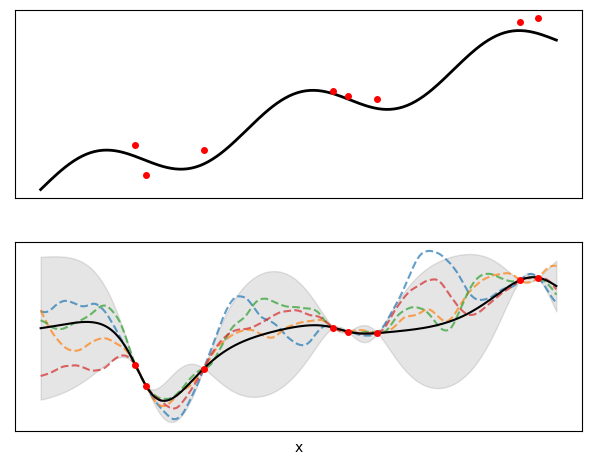

In [4]:
# Now we are going to pick random samples from this function and use those to train our GP model
n_train = 8
x_train = np.random.uniform(domain[0], domain[1], n_train).reshape(-1, 1)
y_train = objective_function(x_train).flatten()

# Now train/fit the model
model = GaussianProcessRegressor(
    kernel=gp.kernels.Matern(nu=2.5),  # Matern 5/2 kernel
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=3
)
# This will automatically perform the optimization of the log-marginal likelihood
# to determine the kernel hyperparameters.
model.fit(x_train, y_train)
# DEBUG - print out the optimized hyperparameters
print(f"Optimized kernel parameters: {model.kernel_}")

# Now we sample the posterior distribution much more densely than our training points
n = 250
x = np.linspace(domain[0], domain[1], n).reshape(-1, 1)
# This returns a mean value and a standard deviation for each sample point we requested
mu, sd = model.predict(x, return_std=True)

# Get the truth data (i.e. densely sampled without noise)
y_true = objective_function(x, sigma=0.0).flatten()

# Visualize the data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
plt.tight_layout()
# Plot truth and samples
ax1.plot(x, y_true, "k", lw=2)
ax1.plot(x_train, y_train, "or", ms=4)

# Plot posterior samples
plot_gpr_samples(model, x, 4, ax2)
ax2.plot(x_train, y_train, "or", ms=4)
ax2.set_xlabel("x")

# Turn off axis labels
for ax in [ax1, ax2]:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


### Acquisition Functions:
Now, we will plot the 3 acquisition functions that we are interested in
studying using the generated data above.

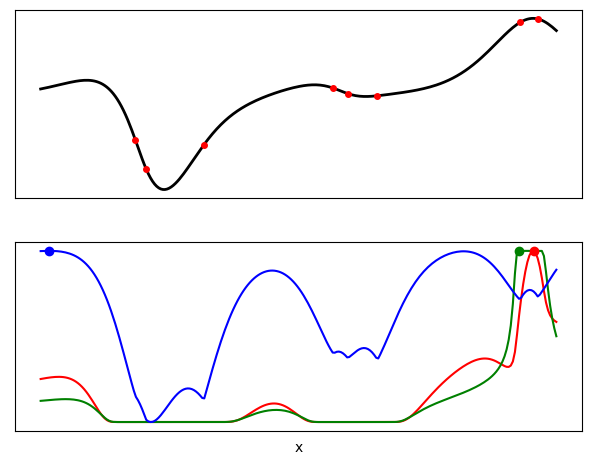

In [5]:
def acquisition_fn(acq_func: str, mean, std, x: np.array, f_best):
    mean = mean.reshape(x.shape[0], -1)
    std = std.reshape(x.shape[0], -1)

    # Negative sign because scipy.optimize.minimize needs to maximize this function
    if acq_func == "EI":
        num = (mean - f_best)
        gamma = num / std
        return num * norm.cdf(gamma) + std * norm.pdf(gamma)
    elif acq_func == "PI":
        return norm.cdf((mean - f_best) / std)
    elif acq_func == "UCB":
        kappa = 2.5
        return mean + kappa * std
    else:
        raise NotImplementedError()


# Visualize the data
fig2, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
plt.tight_layout()
# Plot posterior samples
ax1.plot(x, mu, "k", lw=2)
ax1.plot(x_train, y_train, "or", ms=4)

# Plot the acquisition functions (normalize so they are all on the same scale)
f_best = y_true.max()
ei = normalize(acquisition_fn("EI", mu, sd, x, f_best))
pi = normalize(acquisition_fn("PI", mu, sd, x, f_best))
ucb = normalize(acquisition_fn("UCB", mu, sd, x, f_best))
ax2.plot(x, ei, "r")
ax2.plot(x, pi, "g")
ax2.plot(x, ucb, "b")

# Plot the acquisition function maximums
ax2.plot(x[np.argmax(ei)], ei.max(), "ro")
ax2.plot(x[np.argmax(pi)], pi.max(), "go")
ax2.plot(x[np.argmax(ucb)], ucb.max(), "bo")
ax2.set_xlabel("x")

# Turn off axis labels
for ax in [ax1, ax2]:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


### Expected Improvement Acquisition Function varying with GPR hyperparameters:

Optimized kernel parameters: Matern(length_scale=0.3, nu=2.5)
Optimized kernel parameters: Matern(length_scale=1, nu=2.5)
Optimized kernel parameters: Matern(length_scale=8, nu=2.5)


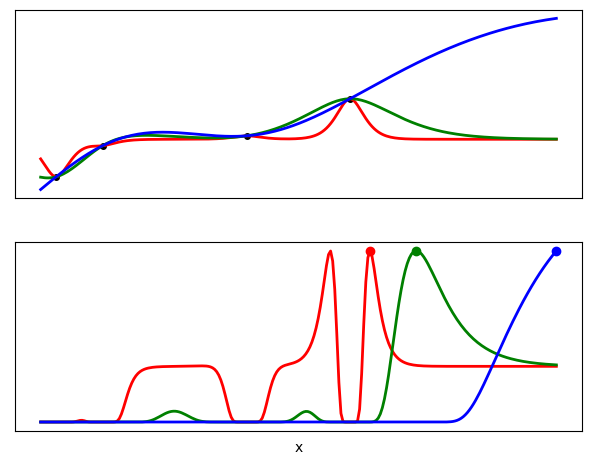

In [6]:
# Now, we will show how the expected improvement acquisition function will varying with
# the hyperparameters used for the GPR.

# Hand pick the samples that we are going to use, we do this so that they are sufficiently
# spread out and the length scale can lead to variance "freely" in between samples
x_train = np.array([0.3, 1.2, 4.0, 6.0]).reshape(-1, 1)
y_train = objective_function(x_train).flatten()

# We are going to show how varying the model length scale effects the posterior predictions (3 different sets)
optimal_ls = 3.6
length_scales = [(0.1, 0.3), (1.0, 3.0), (8.0, 10.0)]
means = []  # Means for each parameter set
stds = []  # Standard Deviations for each parameter set
for ls in length_scales:
    # Ignore sklearn's GP convergence warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Refit the model for each parameter set
        # Now train/fit the model
        model = GaussianProcessRegressor(
            kernel=gp.kernels.Matern(nu=2.5, length_scale_bounds=ls),  # Matern 5/2 kernel
            alpha=1e-6,
            normalize_y=True,
            n_restarts_optimizer=5,
            random_state=3
        )
        model.fit(x_train, y_train)
        # DEBUG - print out the optimized hyperparameters
        print(f"Optimized kernel parameters: {model.kernel_}")
        # Predict over the full domain
        mu, sd = model.predict(x, return_std=True)
        means.append(mu)
        stds.append(sd)

fig3, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
plt.tight_layout()
ax1.plot(x_train, y_train, "ok", ms=4)
for mu, sd, color in zip(means, stds, ["r", "g", "b"]):
    # Plot the posterior approximation of the objective function
    ax1.plot(x, mu, color, lw=2)
    # Plot the Expected improvement
    f_best = y_true.max()
    ei = normalize(acquisition_fn("EI", mu, sd, x, f_best))
    ax2.plot(x, ei, color, lw=2)
    # Plot the acquisition function maximums
    ax2.plot(x[np.argmax(ei)], ei.max(), f"{color}o")
ax2.set_xlabel("x")

# Turn off axis labels
for ax in [ax1, ax2]:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### Bayesian Optimization performance test

#### Define the objective function

In [7]:
# We are going to test how well the optimizer can find the Branin-Hoo function minimum
# over all acquisition functions and over a few different iteration sizes
def branin_hoo_function(x1, x2):
    # SEE: https://statisticaloddsandends.wordpress.com/2019/06/24/test-functions-for-optimization-and-the-branin-hoo-function/
    a = 1
    b = 5.1 / (4 * math.pi**2)
    c = 5 / math.pi
    r = 6
    s = 10
    t = 1 / (8 * math.pi)
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*math.cos(x1) + s

#### Visualize the Branin-Hoo function

[49 62]
0.40307127299759316


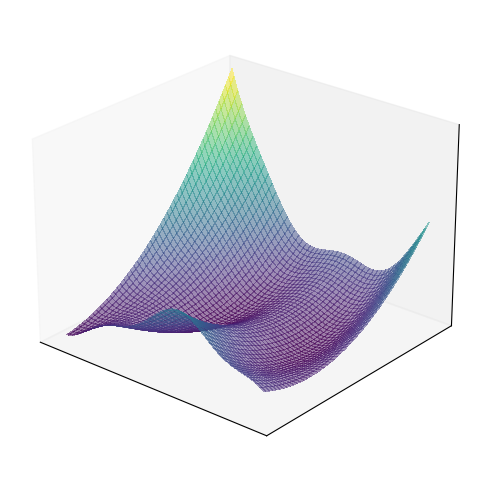

In [8]:
x_axis = np.linspace(0, 15, 100)
y_axis = np.linspace(-5, 10, 100)
XA, YA = np.meshgrid(x_axis, y_axis)
vfunc = np.vectorize(branin_hoo_function)
Z = vfunc(XA, YA)


# Visualize the function as a surface plot
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(XA, YA, Z, cmap=cm.viridis,
                       linewidth=0, antialiased=False, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(25, 130)

true_x_min = np.argwhere(Z == np.min(Z))[0]
print(true_x_min)
print(Z[true_x_min[0], true_x_min[1]])

#### Do the optimization:

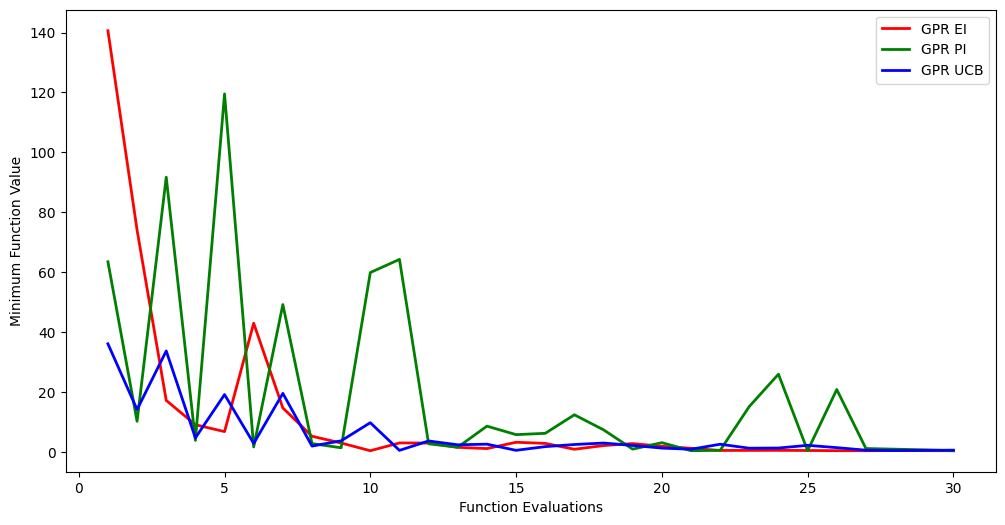

In [9]:
# Define the function domain bounds
bounds = [(0, 15), (-5, 15)]
pbounds = {'x1': (0, 15), 'x2': (-5, 15)}

results = {}
iterations = np.arange(1, 31, 1, dtype=np.int16).tolist()
acq_funcs = [AcquisitionFunc.EI, AcquisitionFunc.PI, AcquisitionFunc.UCB]

for acq_func in acq_funcs:
    results[acq_func] = []
    for n_iter in iterations:
        # Preform the optimization
        optimizer = BayesianOptimizer(
            lambda x1, x2: -1 * branin_hoo_function(x1, x2),
            n_iter, 1, bounds, acq_func, debug=False, verbose=False)
        optimal = optimizer.maximize()
        results[acq_func].append(-1 * optimal[0])

# Plot the results
# Visualize the function as a surface plot
fig4 = plt.figure(figsize=(12, 6))
ax = fig4.gca()
ax.plot(iterations, results[AcquisitionFunc.EI], "r", lw=2, label="GPR EI")
ax.plot(iterations, results[AcquisitionFunc.PI], "g", lw=2, label="GPR PI")
ax.plot(iterations, results[AcquisitionFunc.UCB], "b", lw=2, label="GPR UCB")
ax.set_xlabel("Function Evaluations")
ax.set_ylabel("Minimum Function Value")
plt.legend()
plt.show()
